In [1]:
!pip install kmodes #installing kmodes

In [2]:
!pip install umap-learn #installing umap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=f0acef78fc55387c7999df3aa267faab13401413ee9377bda6fcd8fd8238ae8b
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=72b8f3dcf705de1f4dac4a30a88aa882763bfbcb8d3d7a2a90153a749a2b469c
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [3]:
!pip install shap #install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.2 MB/s eta 0:00:00


In [4]:
#importing necessary librararies
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
from plotnine import *
import plotnine
import warnings
warnings.filterwarnings('ignore',category = FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
import umap
from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score

In [5]:
#loading the pre dataset comprising of 2018,2019

df_18 = pd.read_csv('/content/category_2018.csv')
df_19 = pd.read_csv('/content/category_2019.csv')

print('Dimension data: {} rows & {} columns'.format(len(df_18),len(df_18.columns)))
print('Dimension data: {} rows & {} columns'.format(len(df_19),len(df_19.columns)))

Dimension data: 3879 rows & 31 columns
Dimension data: 3224 rows & 31 columns


In [6]:
#loading the post dataset comprising 2020,2021

df_20 = pd.read_csv('/content/category_2020.csv')
df_21 = pd.read_csv('/content/category_2021.csv')
print('Dimension data: {} rows & {} columns'.format(len(df_20),len(df_20.columns)))
print('Dimension data: {} rows & {} columns'.format(len(df_21),len(df_21.columns)))

Dimension data: 3964 rows & 33 columns
Dimension data: 6250 rows & 33 columns


In [7]:
df_pre = pd.concat([df_18, df_19], ignore_index=True) #concateniating the two sets 2018,2019
print('Dimension data: {} rows & {} columns'.format(len(df_pre),len(df_pre.columns)))

Dimension data: 7103 rows & 31 columns


In [8]:
df_post = pd.concat([df_20,df_21], ignore_index=True) #concatenatingthe two sets 2020,2021
print('Dimension data: {} rows & {} columns'.format(len(df_post),len(df_post.columns)))

Dimension data: 10214 rows & 33 columns


Pre Data Analyses


Data cleaning


In [9]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7103 entries, 0 to 7102
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rsex       7103 non-null   object
 1   ReligSum   7103 non-null   object
 2   SupParty   7103 non-null   object
 3   ClosePty   7103 non-null   object
 4   PartyIDN   5996 non-null   object
 5   Politics   7103 non-null   int64 
 6   Spend1     7103 non-null   object
 7   TaxSpend   6890 non-null   object
 8   AnyBN3     7103 non-null   object
 9   Dole       7103 non-null   object
 10  dolefidl   7103 non-null   int64 
 11  sochelp    7103 non-null   int64 
 12  welfhelp   7103 non-null   int64 
 13  damlives   7103 non-null   int64 
 14  proudwlf   7103 non-null   int64 
 15  redistrb   7103 non-null   int64 
 16  richlaw    7103 non-null   int64 
 17  wealth     7103 non-null   int64 
 18  indust4    7103 non-null   int64 
 19  BigBusnn   7103 non-null   int64 
 20  deathapp   7103 non-null   int

In [11]:
df_pre = df_pre.dropna() #droppinh null values
print('Dimension data: {} rows & {} columns'.format(len(df_pre),len(df_pre.columns)))

Dimension data: 5821 rows & 31 columns


In [12]:
#removal of responses that are not necessary

ordinal_columns_pre = ['welfhelp','sochelp','dolefidl','damlives','proudwlf','redistrb','BigBusnn','wealth',
                 'richlaw','indust4','tradvals','stifsent','deathapp','censor','wronglaw','Politics']
values_to_remove_pre = [-1.0, -11.0, 9.0, -2.0,-1,8.0,-2.0]

for column in ordinal_columns_pre:
    df_pre = df_pre[~df_pre[column].isin(values_to_remove_pre)]

In [13]:
print('Dimension data: {} rows & {} columns'.format(len(df_pre),len(df_pre.columns)))

Dimension data: 4534 rows & 31 columns


gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable


Shape of embedding: (4534, 2)


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


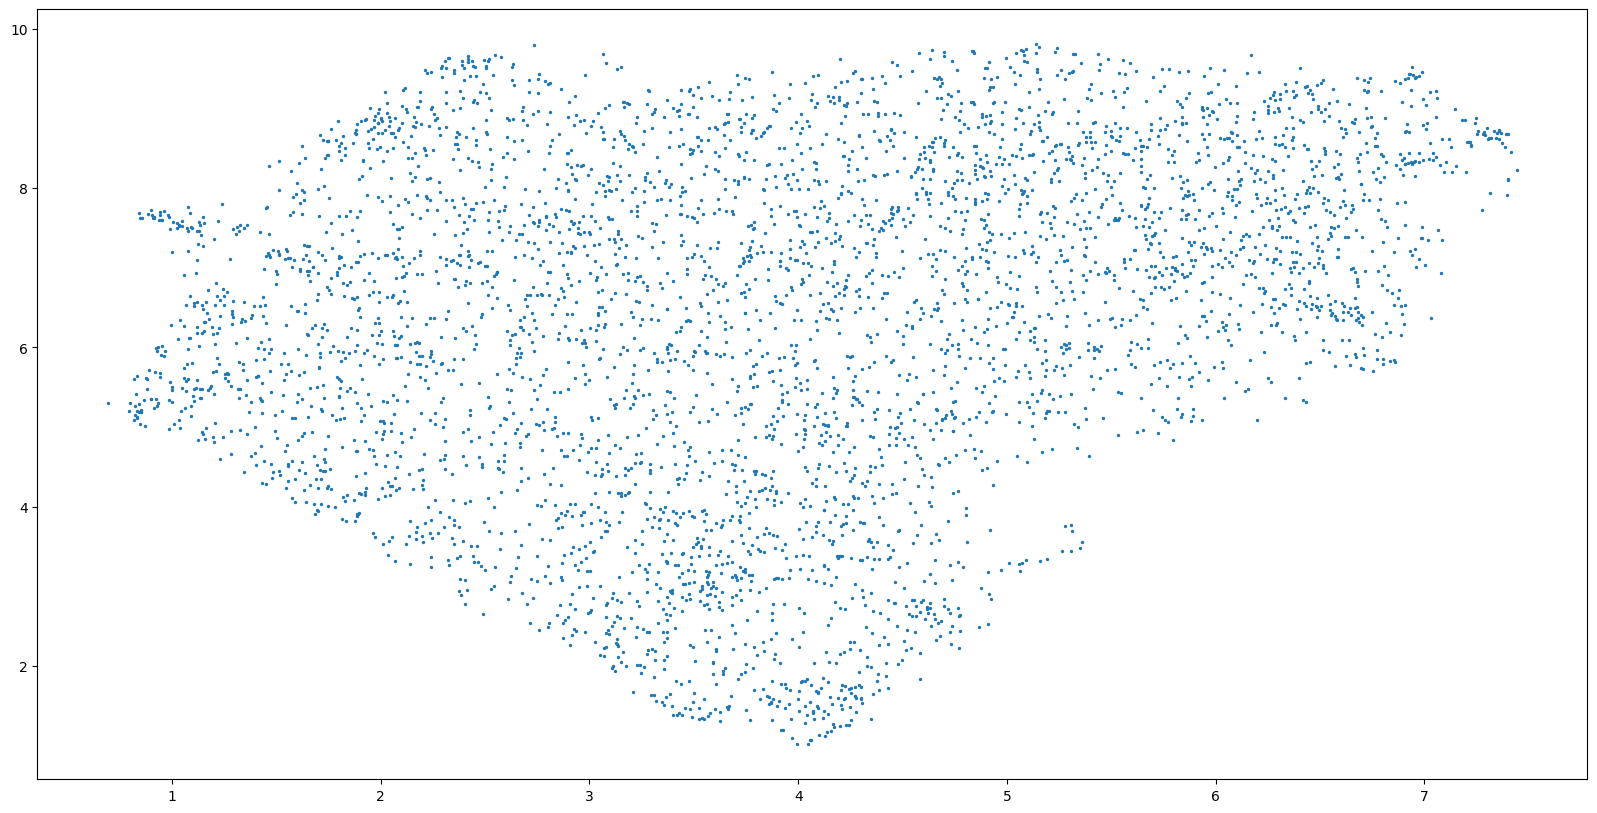

In [14]:

#UMAP dimensionality reduction for pre dataset
# ordinal data filtered out
ordinal = df_pre.select_dtypes(exclude='object')

# Preprocessing of categorical columns
categorical = df_pre.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

# Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df_pre.select_dtypes(include='object').columns) /df_pre.shape[1]

# Embedding ordinal & categorical
fit1 = umap.UMAP(metric='l2').fit(ordinal)
fit2 = umap.UMAP(metric='dice').fit(categorical)

# Augmenting the ordinal embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)

# simplicial_set_embedding
embedding, _ = umap.umap_.simplicial_set_embedding(
    fit1._raw_data, intersection, fit1.n_components,
    fit1._initial_alpha, fit1._a, fit1._b,
    fit1.repulsion_strength, fit1.negative_sample_rate,
    200, 'random', np.random, fit1.metric,
    fit1._metric_kwds, False, densmap_kwds=None, output_dens=None  # Add these arguments
)

print("Shape of embedding:", embedding.shape)

# Plot the embedding
plt.figure(figsize=(20, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, cmap='Spectral', alpha=1.0)
plt.show()

In [15]:
kproto_data_pre = df_pre.copy()

In [16]:
#obtaining the positions of categorical columns
catColumnsPos_pre = [kproto_data_pre.columns.get_loc(col) for col in list(kproto_data_pre.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(kproto_data_pre.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos_pre))

Categorical columns           : ['Rsex', 'ReligSum', 'SupParty', 'ClosePty', 'PartyIDN', 'Spend1', 'TaxSpend', 'AnyBN3', 'Dole', 'NatIdGB', 'NHSSat', 'ECPolicy2', 'EURefV2', 'EURefb', 'EUVOTWHO']
Categorical columns position  : [0, 1, 2, 3, 4, 6, 7, 8, 9, 25, 26, 27, 28, 29, 30]


In [17]:
dfMatrix_pre = kproto_data_pre.to_numpy()
dfMatrix_pre

array([['Male', 'Church of England', ' No', ...,
        'Schedule not applicable', 'Schedule not applicable',
        'Schedule not applicable'],
       ['Female', 'No religion', 'Yes', ..., 'Schedule not applicable',
        'Schedule not applicable', 'Schedule not applicable'],
       ['Female', 'No religion', ' No', ..., 'Schedule not applicable',
        'Schedule not applicable', 'Schedule not applicable'],
       ...,
       ['Male', 'No religion', ' No', ..., 'Yes',
        'Remain a member of the European Union',
        'Remain a member of the European Union '],
       ['Male', 'No religion', ' No', ..., 'Schedule not applicable',
        'Schedule not applicable', 'Schedule not applicable'],
       ['Male', 'Church of England', 'Yes', ..., 'No',
        'Leave the European Union',
        'skip, didnt return SC questionnaire']], dtype=object)

In [18]:
#executing k-prototype clustering for predata
kprototype = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', random_state = 0)
clusters = kprototype.fit_predict(dfMatrix_pre, categorical = catColumnsPos_pre)

In [19]:
cluster_centroids_pre = kprototype.cluster_centroids_
cluster_centroids_pre

array([['2.914067914067914', '2.8967428967428965', '2.997920997920998',
        '2.986139986139986', '2.6590436590436592', '2.4736659736659736',
        '3.0765765765765765', '2.471933471933472', '2.4885654885654884',
        '2.53984753984754', '2.571032571032571', '2.189189189189189',
        '2.5675675675675675', '2.3021483021483022', '2.0405405405405403',
        '1.8045738045738047', 'Female', 'No religion', ' No',
        'Item not applicable', 'Conservative', 'Schedule not applicable',
        'Increase tax and spend more on health, education and social benefits',
        'Yes', 'benefits for unemployed people are too high and disc',
        'Equally (English/Scottish/Welsh) and British',
        'Quite satisfied', 'Schedule not applicable',
        'Schedule not applicable', 'Schedule not applicable',
        'Schedule not applicable'],
       ['2.1098300970873787', '3.9866504854368934', '3.9860436893203883',
        '3.6274271844660193', '1.966626213592233', '1.820388349514563

In [20]:
pd.Series(clusters).value_counts()

0    2886
1    1648
dtype: int64

In [21]:
np.unique(clusters)

array([0, 1], dtype=uint16)

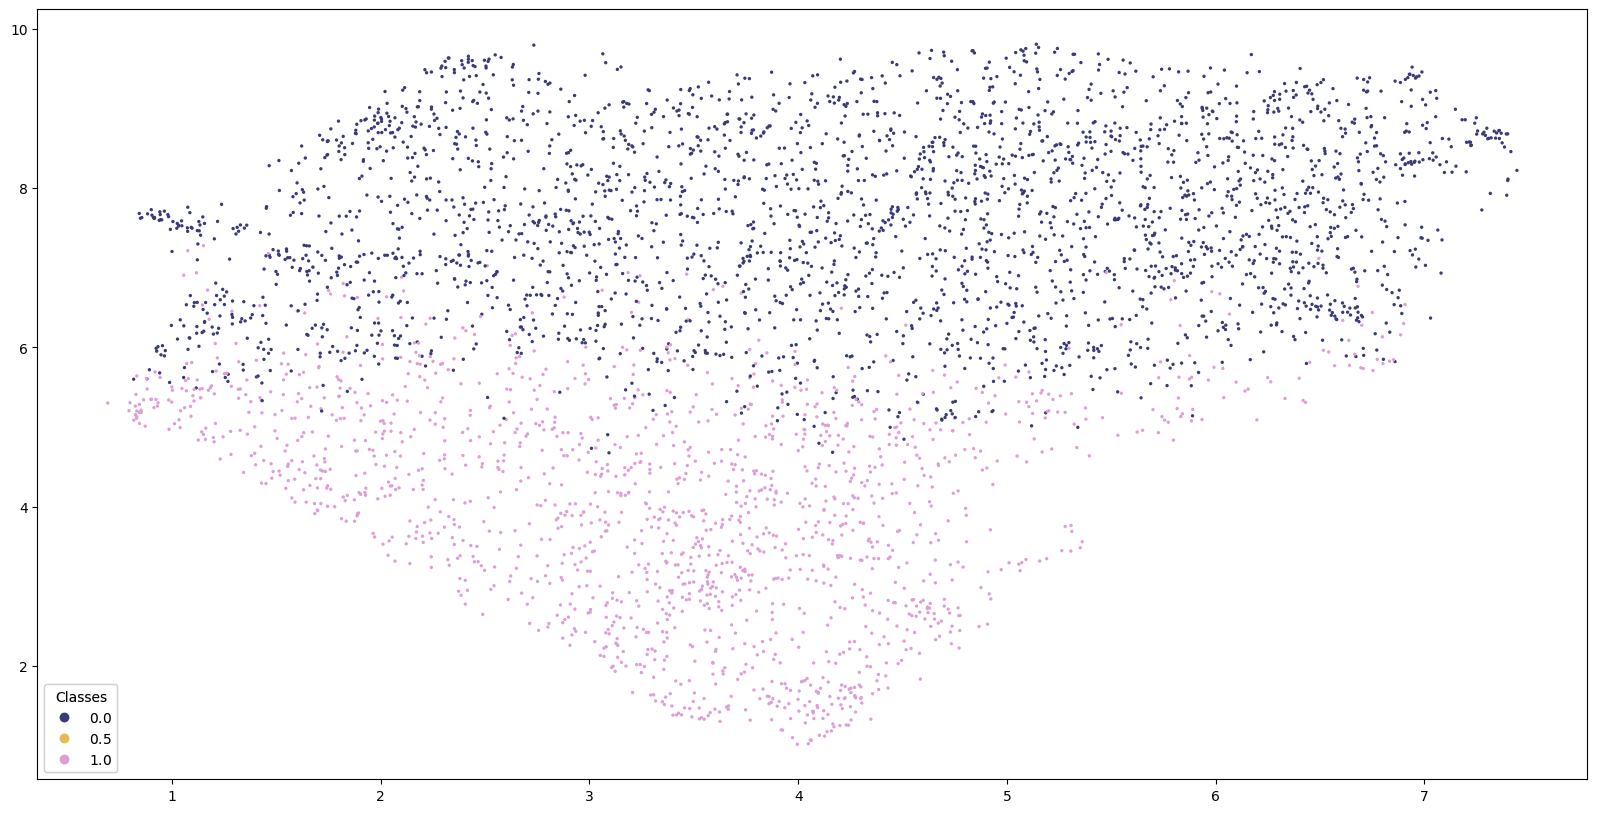

In [22]:
#cluster siolution
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=2),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

post data Analyse

Data Cleaning

In [23]:
df_post = df_post.dropna() #dropping the null values
print('Dimension data: {} rows & {} columns'.format(len(df_post),len(df_post.columns)))

Dimension data: 10214 rows & 33 columns


In [24]:
#removing unrequired resposes
ordinal_columns_post = ['welfhelp','sochelp','dolefidl','damlives','proudwlf','redistrb','BigBusnn','wealth',
                 'richlaw','Indust4','tradvals','stifsent','deathapp','censor','wronglaw','CovWk1','CovWk2','CovWk3','Politics']
values_to_remove_post = [-1.0, -11.0, 9.0, -2.0,-1,8]

for column in ordinal_columns_post:
    df_post = df_post[~df_post[column].isin(values_to_remove_post)]

In [25]:
print('Dimension data: {} rows & {} columns'.format(len(df_post),len(df_post.columns)))

Dimension data: 3880 rows & 33 columns


In [26]:
df_post.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3880 entries, 3 to 10213
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rsex       3880 non-null   object
 1   ReligSum   3880 non-null   object
 2   SupParty   3880 non-null   object
 3   ClosePty   3880 non-null   object
 4   PartyIDN   3880 non-null   object
 5   Politics   3880 non-null   int64 
 6   Spend1     3880 non-null   object
 7   TaxSpend   3880 non-null   object
 8   AnyBN3     3880 non-null   object
 9   Dole       3880 non-null   object
 10  dolefidl   3880 non-null   int64 
 11  sochelp    3880 non-null   int64 
 12  welfhelp   3880 non-null   int64 
 13  damlives   3880 non-null   int64 
 14  proudwlf   3880 non-null   int64 
 15  redistrb   3880 non-null   int64 
 16  richlaw    3880 non-null   int64 
 17  wealth     3880 non-null   int64 
 18  Indust4    3880 non-null   int64 
 19  BigBusnn   3880 non-null   int64 
 20  NatIdGB    3880 non-null   ob

gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable


Shape of embedding: (3880, 2)


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


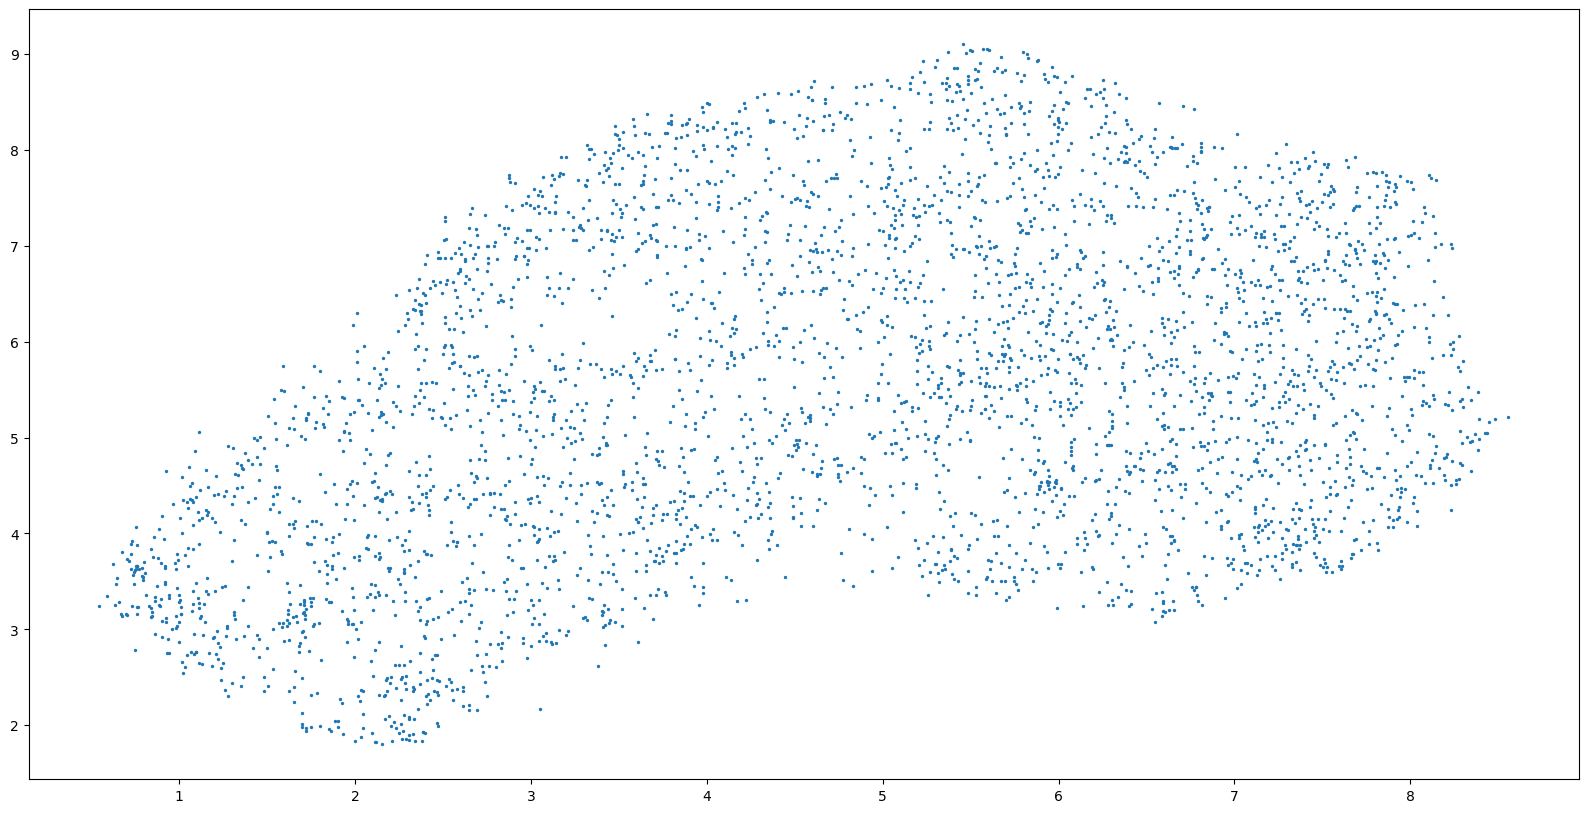

In [27]:
ordinal_post = df_post.select_dtypes(exclude='object')
#for c in numerical.columns:
    #pt = PowerTransformer()
    #numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))

# Preprocessing categorical
categorical_post = df_post.select_dtypes(include='object')
categorical_post = pd.get_dummies(categorical_post)

# Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight_post = len(df_post.select_dtypes(include='object').columns) /df_post.shape[1]

# Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(ordinal_post)
fit2 = umap.UMAP(metric='dice').fit(categorical_post)

# Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight_post)
intersection = umap.umap_.reset_local_connectivity(intersection)

# Manually call simplicial_set_embedding with additional arguments
embedding, _ = umap.umap_.simplicial_set_embedding(
    fit1._raw_data, intersection, fit1.n_components,
    fit1._initial_alpha, fit1._a, fit1._b,
    fit1.repulsion_strength, fit1.negative_sample_rate,
    200, 'random', np.random, fit1.metric,
    fit1._metric_kwds, False, densmap_kwds=None, output_dens=None  # Add these arguments
)
print("Shape of embedding:", embedding.shape)

# Plotting the embedding
plt.figure(figsize=(20, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, cmap='Spectral', alpha=1.0)
plt.show()


In [28]:
kproto_data_post = df_post.copy()

In [29]:
#obtaing categorical column positions
catColumnsPos_post = [kproto_data_post.columns.get_loc(col) for col in list(kproto_data_post.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(kproto_data_post.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos_post))

Categorical columns           : ['Rsex', 'ReligSum', 'SupParty', 'ClosePty', 'PartyIDN', 'Spend1', 'TaxSpend', 'AnyBN3', 'Dole', 'NatIdGB', 'NHSSat', 'ECPolicy2', 'EURefV2', 'EURefb']
Categorical columns position  : [0, 1, 2, 3, 4, 6, 7, 8, 9, 20, 23, 24, 25, 26]


In [30]:
dfMatrix_post = kproto_data_post.to_numpy()
dfMatrix_post

array([['Male', 'Other Christian', ' No', ..., 2, 2, 2],
       ['Female', 'No religion', ' No', ..., 3, 2, 4],
       ['Male', 'Other Christian', 'Yes', ..., 1, 1, 3],
       ...,
       ['Female', 'Other Christian', ' No', ..., 4, 3, 3],
       ['Male', 'Other Christian', ' No', ..., 4, 4, 3],
       ['Female', 'No religion', ' No', ..., 4, 3, 4]], dtype=object)

In [31]:
#executing k-prototype clustering for post dataset
kprototype_post = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', random_state = 0)
clusters_post = kprototype_post.fit_predict(dfMatrix_post, categorical = catColumnsPos_post)

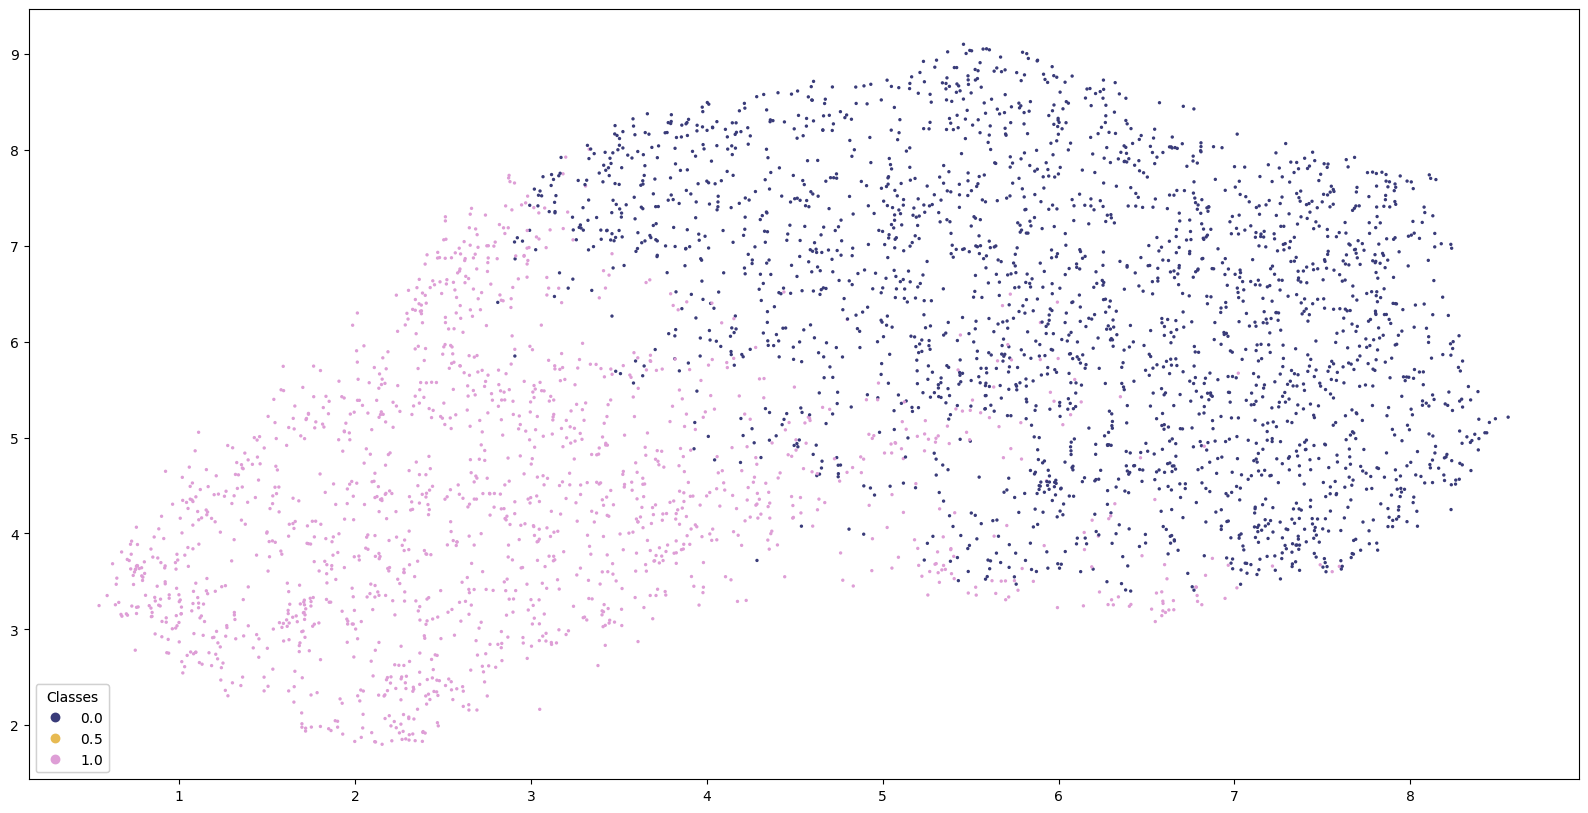

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters_post, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=2),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

In [33]:
pd.Series(clusters_post).value_counts()

0    2329
1    1551
dtype: int64

In [34]:
cluster_centroids_post = kprototype_post.cluster_centroids_
cluster_centroids_post

array([['3.077286389008158', '2.7432374409617863', '2.9042507513954487',
        '2.820523829969944', '2.848862172606269', '2.854014598540146',
        '3.2417346500644055', '2.4881923572348645', '2.4362387290682697',
        '2.6552168312580506', '2.5513095749248604', '2.2086732503220268',
        '1.8492915414340918', '4.075998282524688', '4.249033920137398',
        '4.0734220695577505', '2.580936024044654', '2.674967797337913',
        '2.6633748389866896', 'Female', 'No religion', ' No', ' No',
        'Conservative', 'Item not applicable',
        'Keep taxes and spending on these services at the same level',
        'No', 'benefits for unemployed people are too high and disc',
        'Equally (English/Scottish/Welsh) and British',
        'Item not applicable', 'Item not applicable',
        'skip, didnt return SC questionnaire',
        'skip, didnt return SC questionnaire'],
       ['2.123791102514507', '4.209542230818826', '4.18568665377176',
        '4.0', '1.69696969696969

Evalaution by classification

Pre data clustering

In [35]:
#LightGBM Classifier
lgbm_data = df_pre.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [37]:
#cross validated F1-Score
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 1319, number of negative: 2308
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 199
[LightGBM] [Info] Number of data points in the train set: 3627, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.363661 -> initscore=-0.559507
[LightGBM] [Info] Start training from score -0.559507
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 1318, number of negative: 2309
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

In [38]:
clf_kp.fit(lgbm_data, clusters)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 1648, number of negative: 2886
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 4534, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.363476 -> initscore=-0.560309
[LightGBM] [Info] Start training from score -0.560309


LGBMClassifier(colsample_by_tree=0.8)

In [39]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


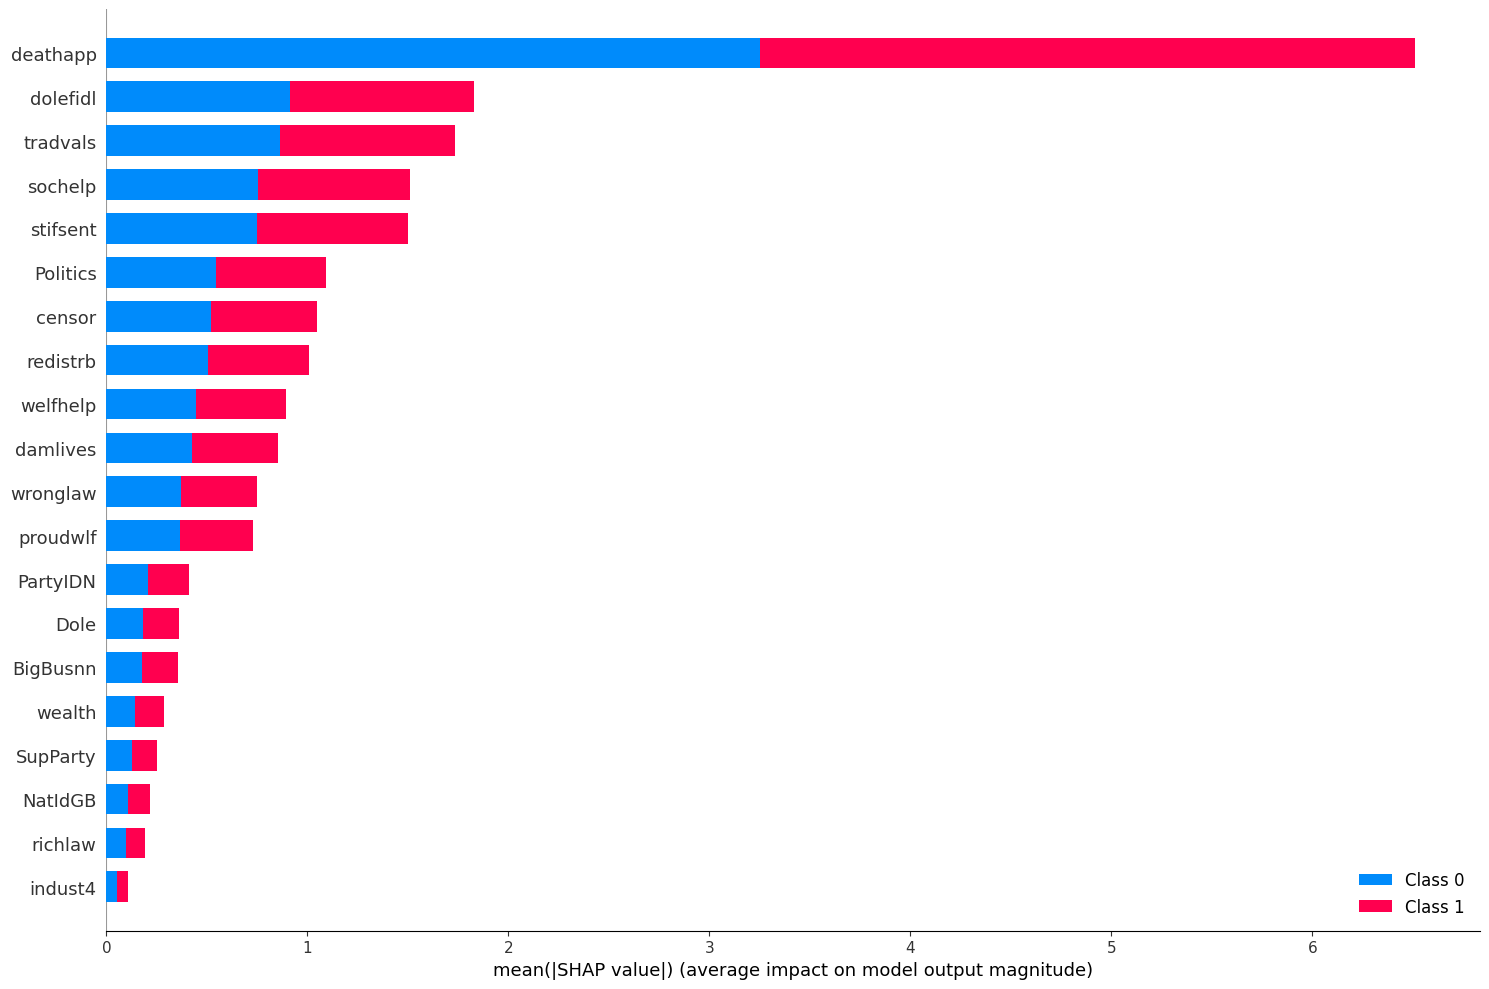

In [40]:
#shap summary plot
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

post data clustering

In [41]:
#LightGBM
lgbm_data_post = df_post.copy()
for c in lgbm_data_post.select_dtypes(include='object'):
    lgbm_data_post[c] = lgbm_data_post[c].astype('category')

In [42]:
clf_kp_post = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp_post = cross_val_score(clf_kp_post, lgbm_data_post, clusters_post, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp_post)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 1241, number of negative: 1863
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 3104, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.399807 -> initscore=-0.406271
[LightGBM] [Info] Start training from score -0.406271
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 1241, number of negative: 1863
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

In [43]:
clf_kp_post.fit(lgbm_data_post, clusters_post)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Number of positive: 1551, number of negative: 2329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 3880, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.399742 -> initscore=-0.406539
[LightGBM] [Info] Start training from score -0.406539


LGBMClassifier(colsample_by_tree=0.8)

In [44]:
explainer_kp_post = shap.TreeExplainer(clf_kp_post)
shap_values_kp_post = explainer_kp_post.shap_values(lgbm_data_post)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


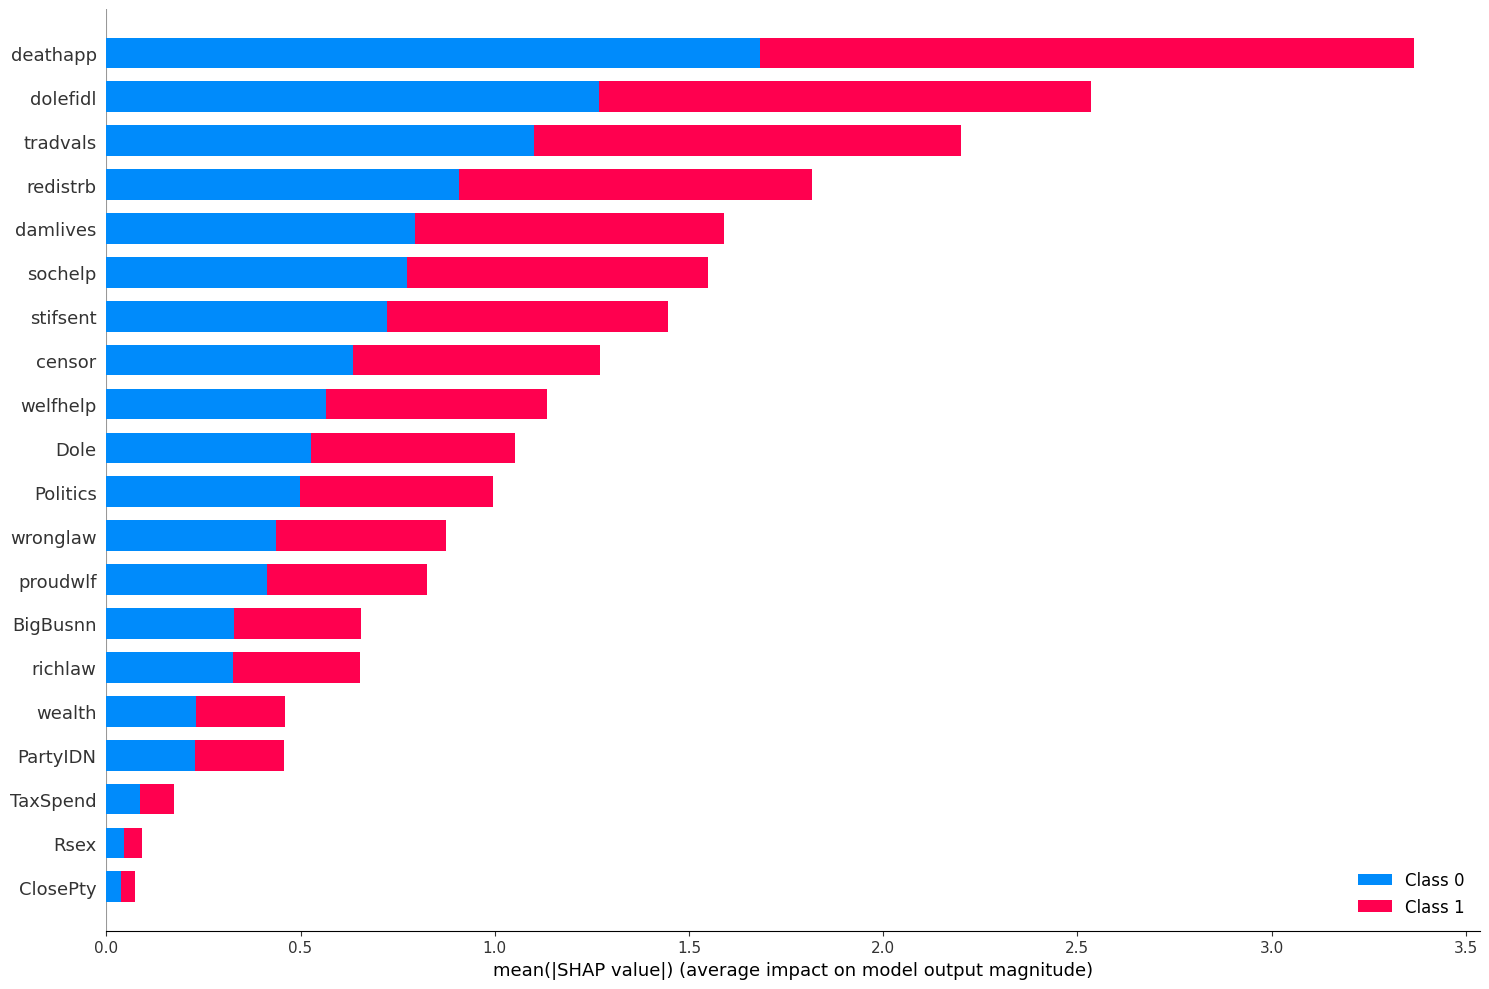

In [45]:
shap.summary_plot(shap_values_kp_post, lgbm_data_post, plot_type="bar", plot_size=(15, 10))

Cluster based attitde analysis

In [46]:
cluster_dict_pre = []
for c in clusters:
  cluster_dict_pre.append(c)

In [47]:
data_pre = df_pre.copy()
data_pre['cluster'] = cluster_dict_pre

In [48]:
cluster_dict_post = []

for c in clusters_post:
  cluster_dict_post.append(c)

In [49]:
data_post = df_post.copy()
data_post['cluster'] = cluster_dict_post
data_post.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3880 entries, 3 to 10213
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rsex       3880 non-null   object
 1   ReligSum   3880 non-null   object
 2   SupParty   3880 non-null   object
 3   ClosePty   3880 non-null   object
 4   PartyIDN   3880 non-null   object
 5   Politics   3880 non-null   int64 
 6   Spend1     3880 non-null   object
 7   TaxSpend   3880 non-null   object
 8   AnyBN3     3880 non-null   object
 9   Dole       3880 non-null   object
 10  dolefidl   3880 non-null   int64 
 11  sochelp    3880 non-null   int64 
 12  welfhelp   3880 non-null   int64 
 13  damlives   3880 non-null   int64 
 14  proudwlf   3880 non-null   int64 
 15  redistrb   3880 non-null   int64 
 16  richlaw    3880 non-null   int64 
 17  wealth     3880 non-null   int64 
 18  Indust4    3880 non-null   int64 
 19  BigBusnn   3880 non-null   int64 
 20  NatIdGB    3880 non-null   ob

EUREFB : If you were given a chance to vote again in referndum,how would you vote

Response : Leave the European union

In [50]:
cluster_leave_percent_pre = data_pre.groupby("cluster")["EURefb"].apply(lambda x: (x == "Leave the European Union").sum() / len(x))
cluster_leave_percent_post= data_post.groupby("cluster")["EURefb"].apply(lambda x: (x == "Leave the European Union").sum() / len(x))


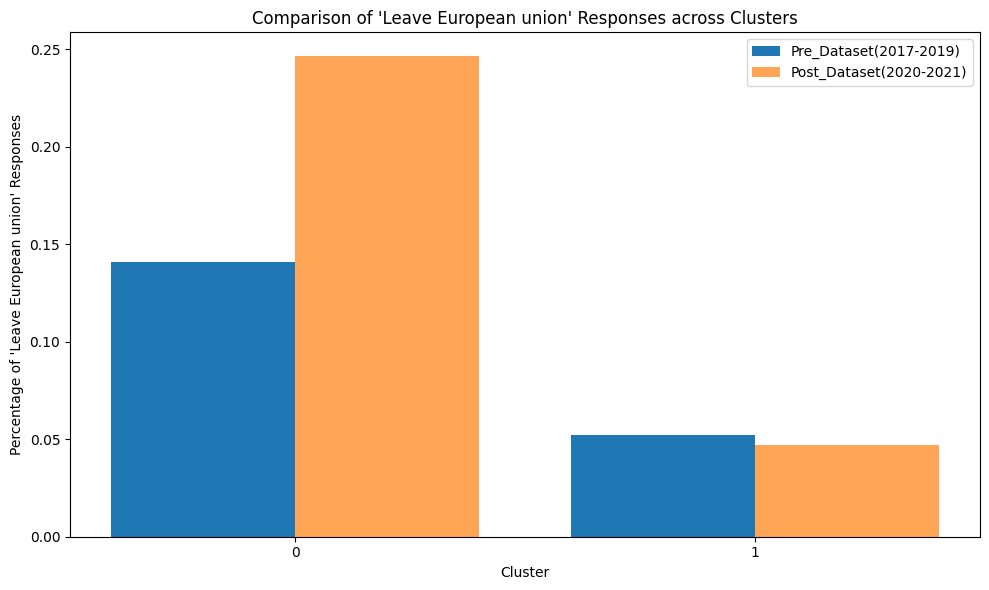

In [51]:
# Creating a bar chart with grouped bars
width = 0.4
plt.figure(figsize=(10, 6))

plt.bar(cluster_leave_percent_pre.index - width/2, cluster_leave_percent_pre.values, width=width, label="Pre_Dataset(2017-2019)")
plt.bar(cluster_leave_percent_post.index + width/2, cluster_leave_percent_post.values, width=width, label="Post_Dataset(2020-2021)", alpha=0.7)

plt.xlabel("Cluster")
plt.ylabel("Percentage of 'Leave European union' Responses")
plt.title("Comparison of 'Leave European union' Responses across Clusters")
plt.legend()
plt.xticks(cluster_leave_percent_pre.index)

plt.tight_layout()
plt.show()

Response : Remain a memmber of the european union

In [52]:
cluster_remain_percent_pre = data_pre.groupby("cluster")["EURefb"].apply(lambda x: (x == "Remain a member of the European Union").sum() / len(x))
cluster_remain_percent_post= data_post.groupby("cluster")["EURefb"].apply(lambda x: (x == "Remain a member of the European Union").sum() / len(x))


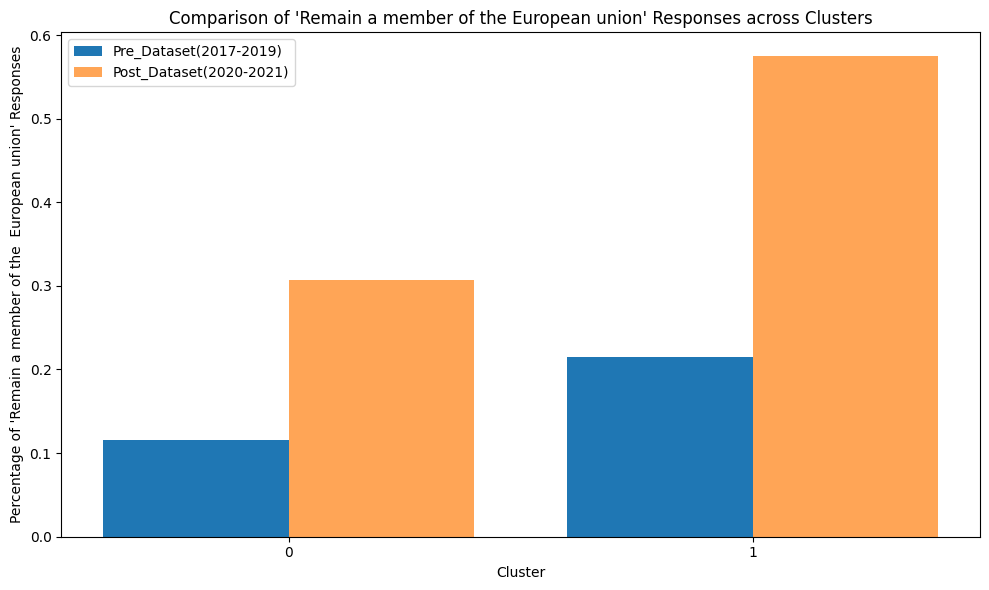

In [53]:
# Creating a bar chart with grouped bars
width = 0.4
plt.figure(figsize=(10, 6))

plt.bar(cluster_remain_percent_pre.index - width/2, cluster_remain_percent_pre.values, width=width, label="Pre_Dataset(2017-2019)")
plt.bar(cluster_remain_percent_post.index + width/2, cluster_remain_percent_post.values, width=width, label="Post_Dataset(2020-2021)", alpha=0.7)

plt.xlabel("Cluster")
plt.ylabel("Percentage of 'Remain a member of the  European union' Responses")
plt.title("Comparison of 'Remain a member of the European union' Responses across Clusters")
plt.legend()
plt.xticks(cluster_remain_percent_pre.index)

plt.tight_layout()
plt.show()

In [54]:
cluster_order = data_pre['cluster'].unique()
cluster_order

array([0, 1], dtype=uint16)

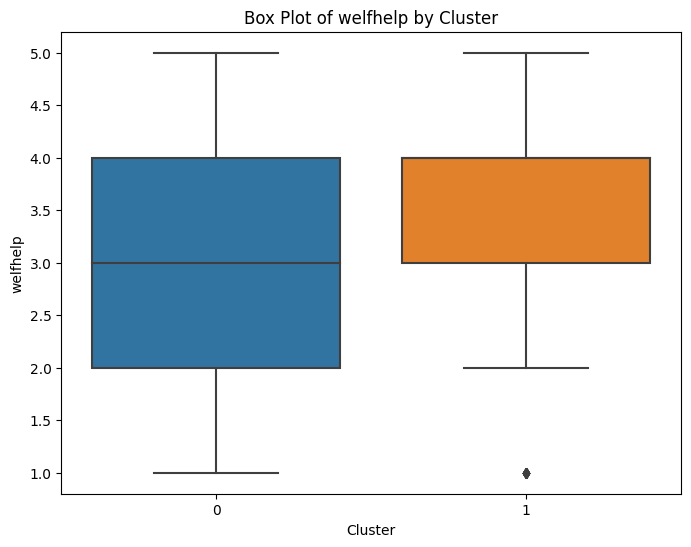

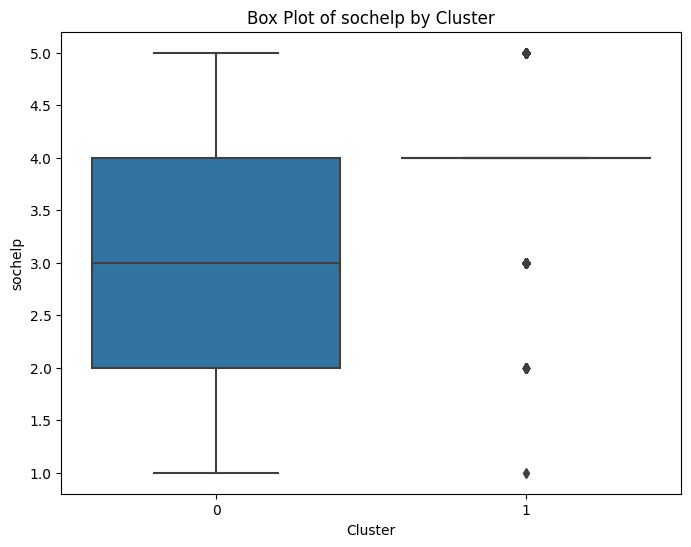

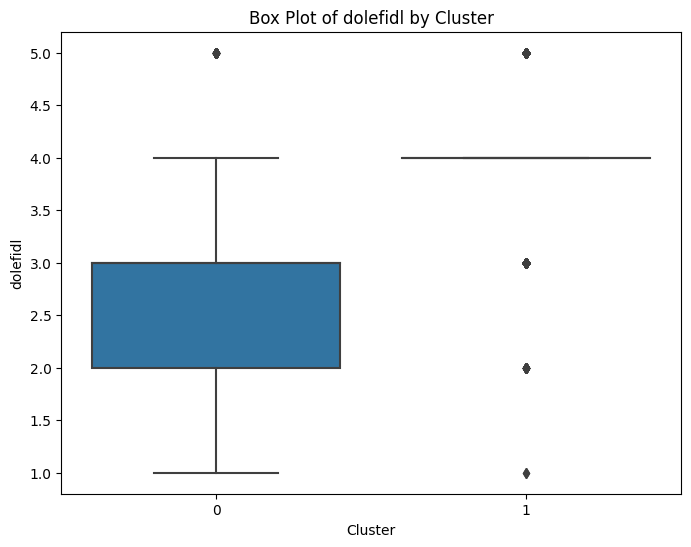

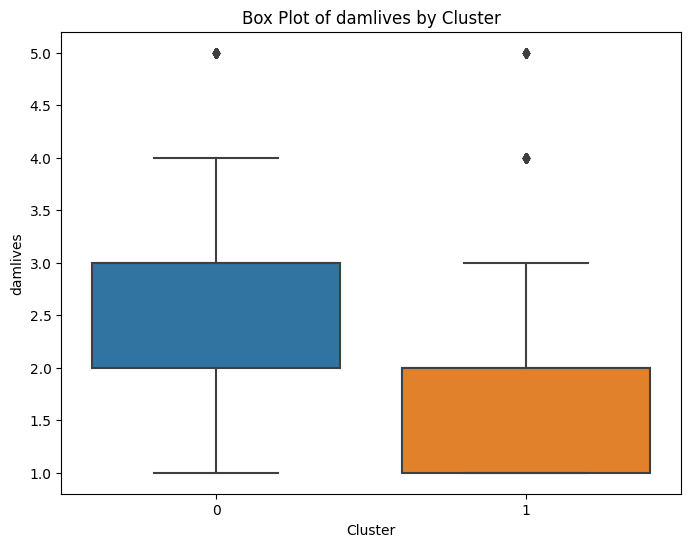

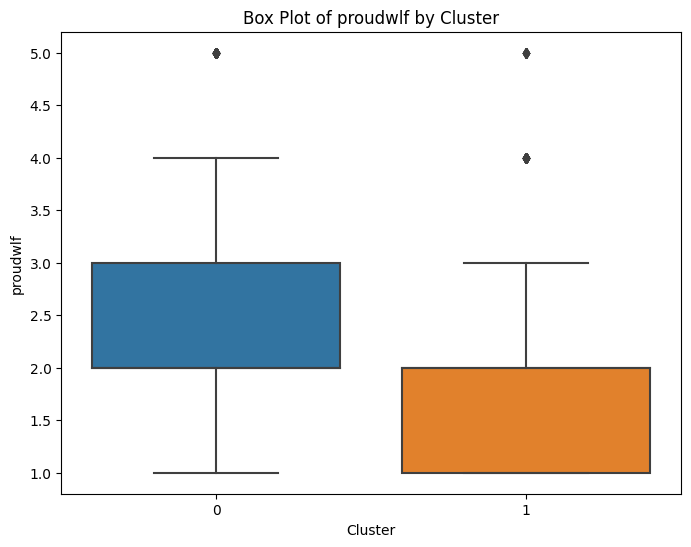

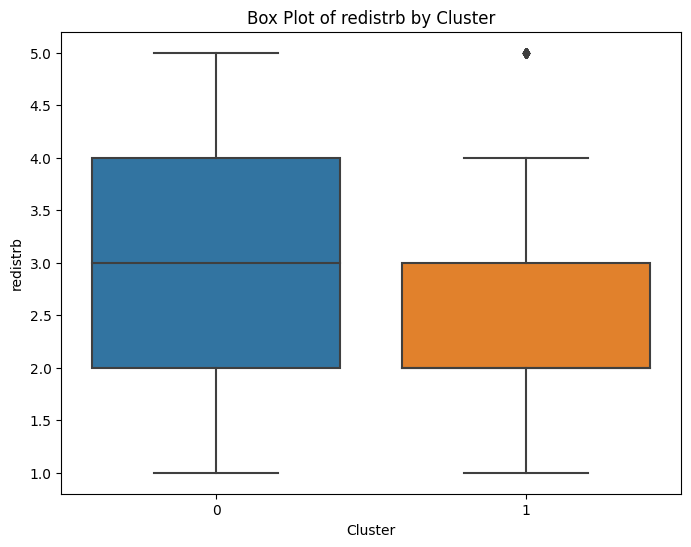

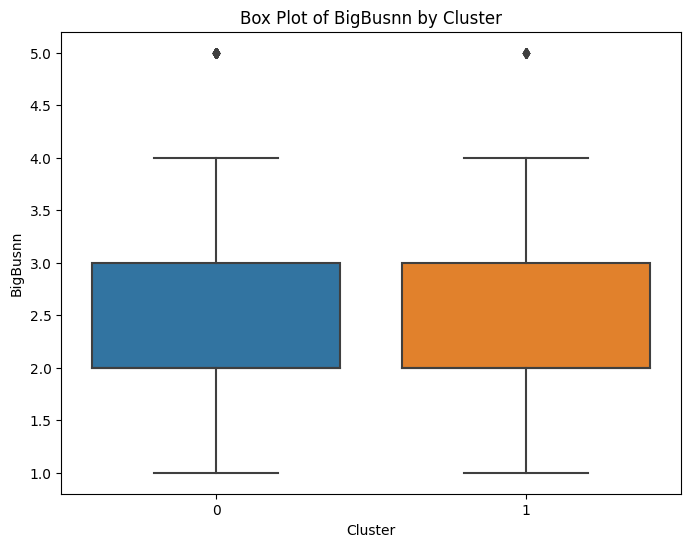

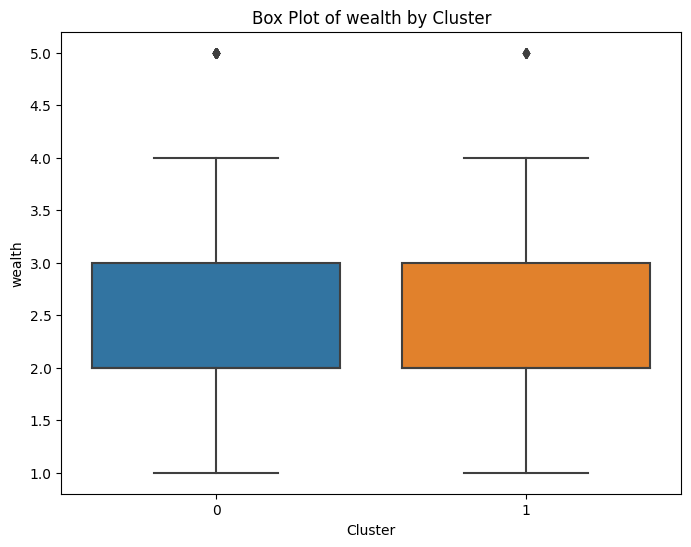

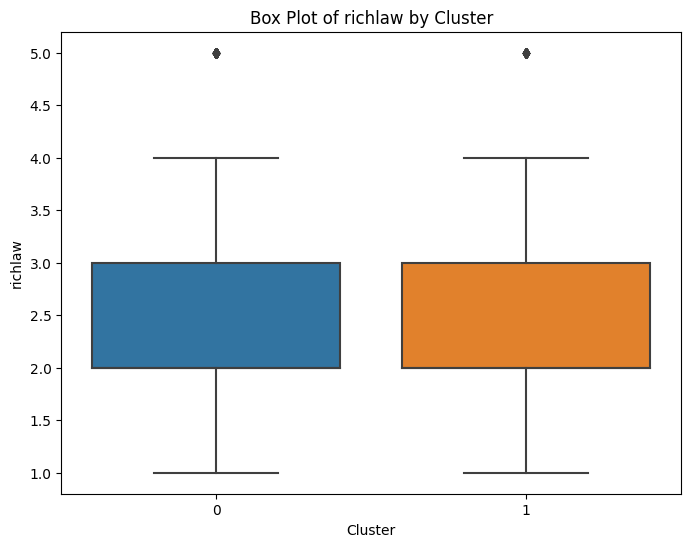

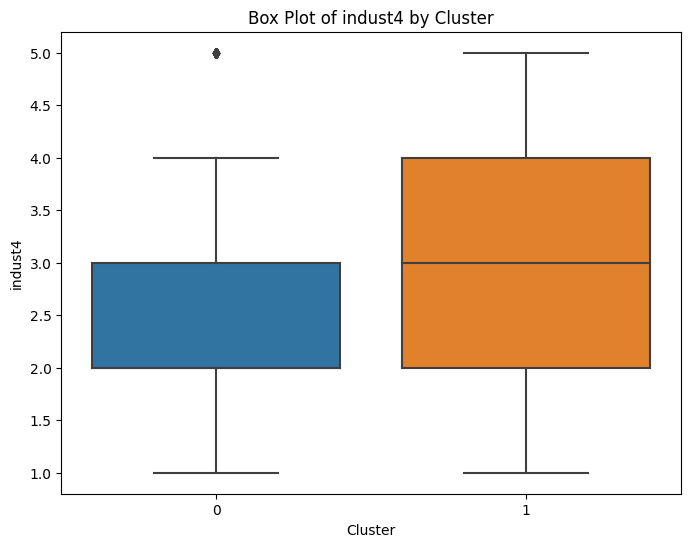

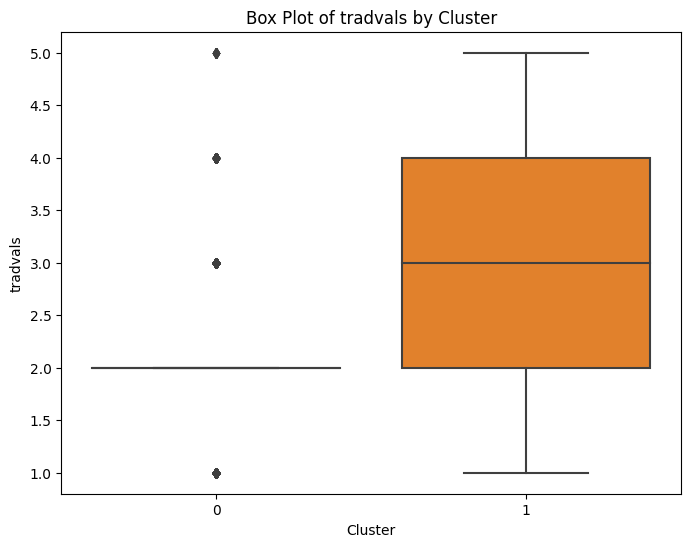

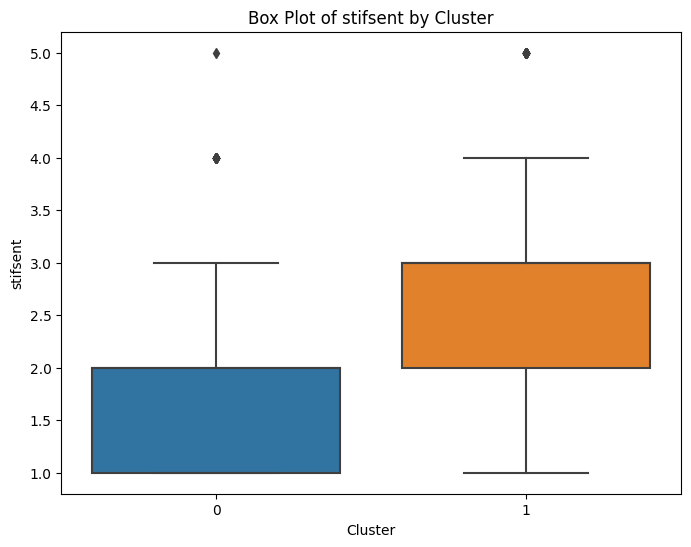

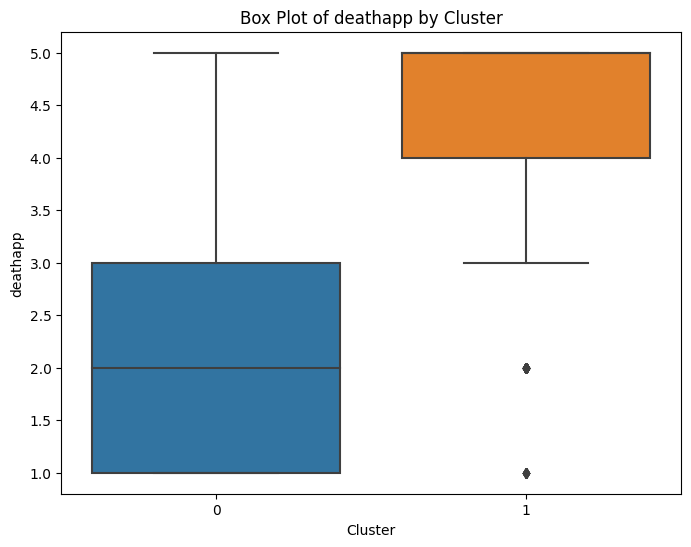

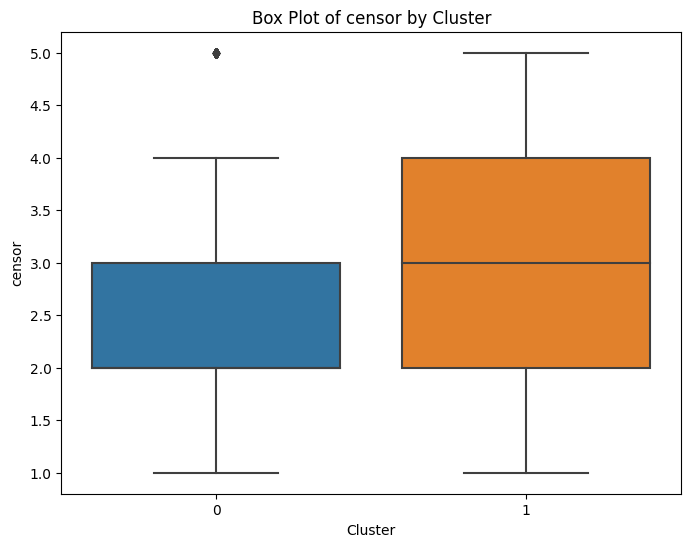

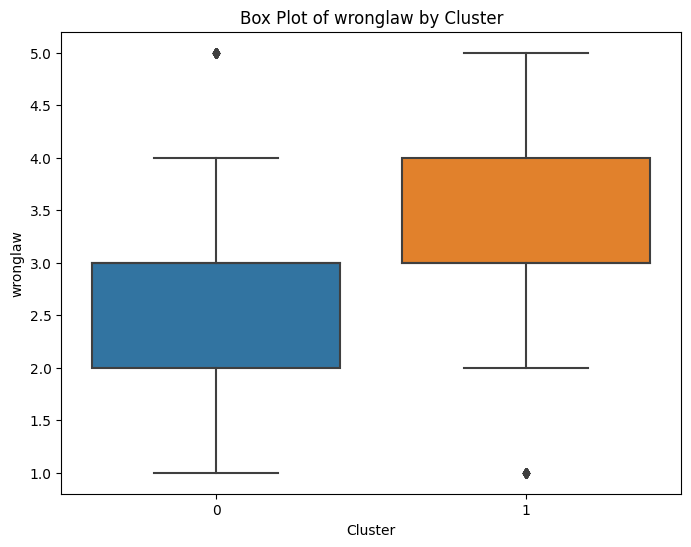

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume you have performed K-Prototypes clustering and have cluster assignments
# stored in a column named 'Cluster' in your DataFrame 'data'.

# Choose the ordinal variables for which you want to create box plots
ordinal_vars = ['welfhelp', 'sochelp', 'dolefidl','damlives','proudwlf',
                'redistrb','BigBusnn','wealth','richlaw','indust4',
                'tradvals','stifsent','deathapp','censor','wronglaw']

# Loop through each ordinal variable and create box plots for each cluster
for var in ordinal_vars:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='cluster', y=var, data=data_pre, order=cluster_order)
    plt.title(f'Box Plot of {var} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(var)
    plt.show()


Ordinal Variables welfhelp

In [56]:
cluster_welf_df_pre = data_pre.groupby("cluster")["welfhelp"].value_counts().unstack(fill_value=0)
cluster_welf_df_post = data_post.groupby("cluster")["welfhelp"].value_counts().unstack(fill_value=0)

In [57]:
cluster_freq_df1_pre = cluster_welf_df_pre.div(cluster_welf_df_pre.sum(axis=1), axis=0)
cluster_freq_df2_post = cluster_welf_df_post.div(cluster_welf_df_post.sum(axis=1), axis=0)

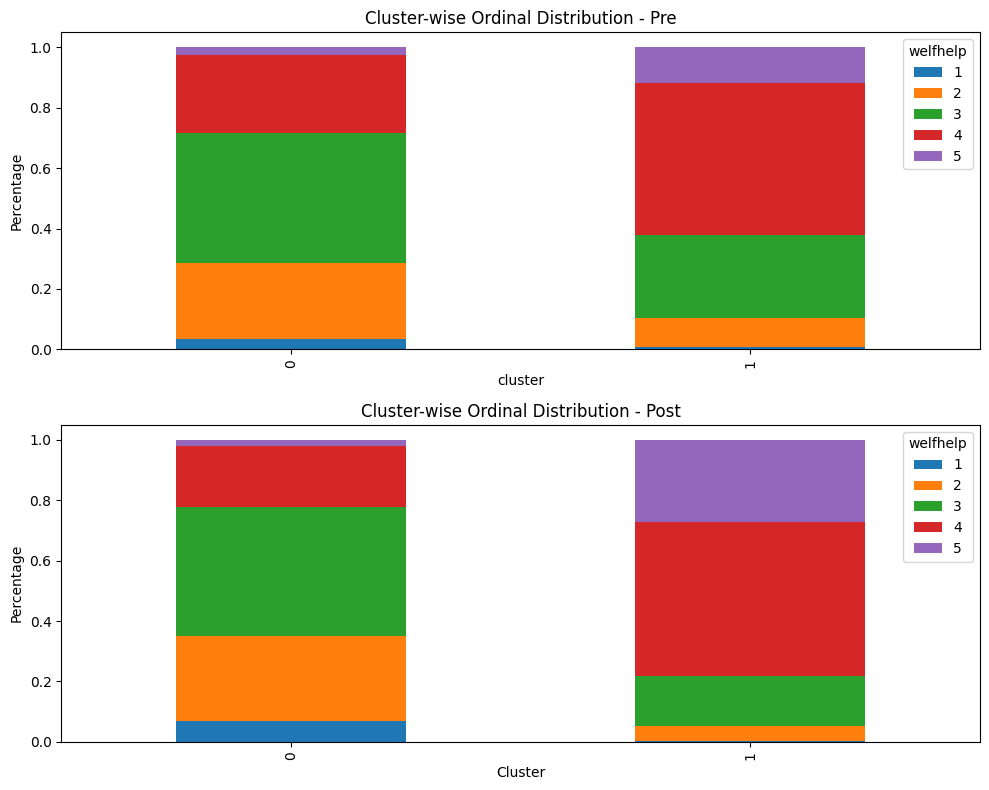

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

cluster_freq_df1_pre.plot(kind="bar", stacked=True, ax=axes[0])
axes[0].set_title("Cluster-wise Ordinal Distribution - Pre")
axes[0].set_ylabel("Percentage")

cluster_freq_df2_post.plot(kind="bar", stacked=True, ax=axes[1])
axes[1].set_title("Cluster-wise Ordinal Distribution - Post")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Percentage")

plt.tight_layout()
plt.show()

In [59]:
ordinal_columns_pre= data_pre.select_dtypes(exclude=['object'])
ordinal_columns_pre

,Politics,dolefidl,sochelp,welfhelp,damlives,proudwlf,redistrb,richlaw,wealth,indust4,BigBusnn,deathapp,wronglaw,censor,tradvals,stifsent,cluster
0,3,4,4,4,2,2,3,3,2,3,2,2,3,2,2,2,0
1,1,5,5,5,1,1,1,1,1,3,2,4,4,2,4,4,1
2,4,3,3,3,4,3,4,3,3,3,3,2,3,4,2,3,0
4,1,4,3,4,4,1,3,1,1,2,2,1,3,2,2,1,0
5,4,3,4,2,3,3,4,2,2,2,2,4,2,2,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7096,2,4,4,2,3,3,3,1,2,2,3,1,2,2,1,1,0
7098,4,5,5,3,1,3,4,3,2,2,2,5,2,3,4,3,1
7099,3,5,4,3,2,3,4,5,5,4,4,4,4,5,2,2,1
7101,2,5,4,2,3,4,4,4,4,3,5,4,2,2,3,3,0


In [60]:
ordinal_columns_post = data_post.select_dtypes(exclude=['object'])

In [61]:
ordinal_columns_post

,Politics,dolefidl,sochelp,welfhelp,damlives,proudwlf,redistrb,richlaw,wealth,Indust4,BigBusnn,tradvals,stifsent,CovWk1,CovWk2,CovWk3,deathapp,censor,wronglaw,cluster
3,2,3,3,2,3,3,4,2,2,3,2,2,1,5,5,5,2,2,2,0
4,3,2,4,3,3,2,4,3,3,4,2,4,3,3,3,3,3,2,4,0
6,3,3,4,3,1,3,1,1,1,1,1,1,1,5,2,3,1,1,3,0
10,4,3,3,2,3,2,4,2,2,1,4,1,1,5,5,5,2,2,2,0
11,3,2,2,2,3,3,2,1,2,2,2,2,2,3,3,3,3,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10207,3,4,4,4,3,3,2,1,1,2,2,5,2,5,5,5,4,3,4,1
10208,2,4,4,4,2,2,3,2,2,2,2,4,4,4,5,4,5,4,4,1
10209,3,2,2,3,3,3,4,3,2,2,2,1,2,4,4,4,4,3,3,0
10210,4,2,2,3,4,4,4,3,2,1,1,1,2,4,4,4,4,4,3,0


In [62]:
import pandas as pd
import numpy as np



# Group data by clusters
pre_clusters = ordinal_columns_pre.groupby('cluster')
post_clusters = ordinal_columns_post.groupby('cluster')

# Function to calculate correlation matrix and similarity
def calculate_similarity(pre_df, post_df):
    correlation_matrix_pre = pre_df.corr()
    correlation_matrix_post = post_df.corr()

    # Calculate similarity using correlation coefficient
    similarity_score = correlation_matrix_pre.corrwith(correlation_matrix_post).mean()

    return similarity_score

# Calculate and compare similarity for each cluster
for cluster_id, pre_cluster_data in pre_clusters:
    post_cluster_data = post_clusters.get_group(cluster_id)

    similarity_score = calculate_similarity(pre_cluster_data, post_cluster_data)

    print(f"Similarity Score for Cluster {cluster_id}: {similarity_score}")


Similarity Score for Cluster 0: 0.9756137237621395
Similarity Score for Cluster 1: 0.989522780619795


In [63]:
clusters


array([0, 1, 0, ..., 1, 0, 0], dtype=uint16)

In [64]:
column_name_mapping = {'Indust4': 'indust4'}
ordinal_columns_post.rename(columns=column_name_mapping, inplace=True)
columns_to_drop = ['CovWk1', 'CovWk2','CovWk3']
ordinal_columns_post.drop(columns=columns_to_drop, inplace=True)

In [65]:
ordi = ordinal_columns_post.copy()

In [66]:
ordi

,Politics,dolefidl,sochelp,welfhelp,damlives,proudwlf,redistrb,richlaw,wealth,indust4,BigBusnn,tradvals,stifsent,deathapp,censor,wronglaw,cluster
3,2,3,3,2,3,3,4,2,2,3,2,2,1,2,2,2,0
4,3,2,4,3,3,2,4,3,3,4,2,4,3,3,2,4,0
6,3,3,4,3,1,3,1,1,1,1,1,1,1,1,1,3,0
10,4,3,3,2,3,2,4,2,2,1,4,1,1,2,2,2,0
11,3,2,2,2,3,3,2,1,2,2,2,2,2,3,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10207,3,4,4,4,3,3,2,1,1,2,2,5,2,4,3,4,1
10208,2,4,4,4,2,2,3,2,2,2,2,4,4,5,4,4,1
10209,3,2,2,3,3,3,4,3,2,2,2,1,2,4,3,3,0
10210,4,2,2,3,4,4,4,3,2,1,1,1,2,4,4,3,0


In [67]:


# Reorder df2 columns to match the column order of df1
ordi = ordi[ordinal_columns_pre.columns]

# Now, both DataFrames have the same column order
ordi

,Politics,dolefidl,sochelp,welfhelp,damlives,proudwlf,redistrb,richlaw,wealth,indust4,BigBusnn,deathapp,wronglaw,censor,tradvals,stifsent,cluster
3,2,3,3,2,3,3,4,2,2,3,2,2,2,2,2,1,0
4,3,2,4,3,3,2,4,3,3,4,2,3,4,2,4,3,0
6,3,3,4,3,1,3,1,1,1,1,1,1,3,1,1,1,0
10,4,3,3,2,3,2,4,2,2,1,4,2,2,2,1,1,0
11,3,2,2,2,3,3,2,1,2,2,2,3,2,3,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10207,3,4,4,4,3,3,2,1,1,2,2,4,4,3,5,2,1
10208,2,4,4,4,2,2,3,2,2,2,2,5,4,4,4,4,1
10209,3,2,2,3,3,3,4,3,2,2,2,4,3,3,1,2,0
10210,4,2,2,3,4,4,4,3,2,1,1,4,3,4,1,2,0


In [68]:
ordinal_columns_pre

,Politics,dolefidl,sochelp,welfhelp,damlives,proudwlf,redistrb,richlaw,wealth,indust4,BigBusnn,deathapp,wronglaw,censor,tradvals,stifsent,cluster
0,3,4,4,4,2,2,3,3,2,3,2,2,3,2,2,2,0
1,1,5,5,5,1,1,1,1,1,3,2,4,4,2,4,4,1
2,4,3,3,3,4,3,4,3,3,3,3,2,3,4,2,3,0
4,1,4,3,4,4,1,3,1,1,2,2,1,3,2,2,1,0
5,4,3,4,2,3,3,4,2,2,2,2,4,2,2,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7096,2,4,4,2,3,3,3,1,2,2,3,1,2,2,1,1,0
7098,4,5,5,3,1,3,4,3,2,2,2,5,2,3,4,3,1
7099,3,5,4,3,2,3,4,5,5,4,4,4,4,5,2,2,1
7101,2,5,4,2,3,4,4,4,4,3,5,4,2,2,3,3,0


Pre-Brexit Data:


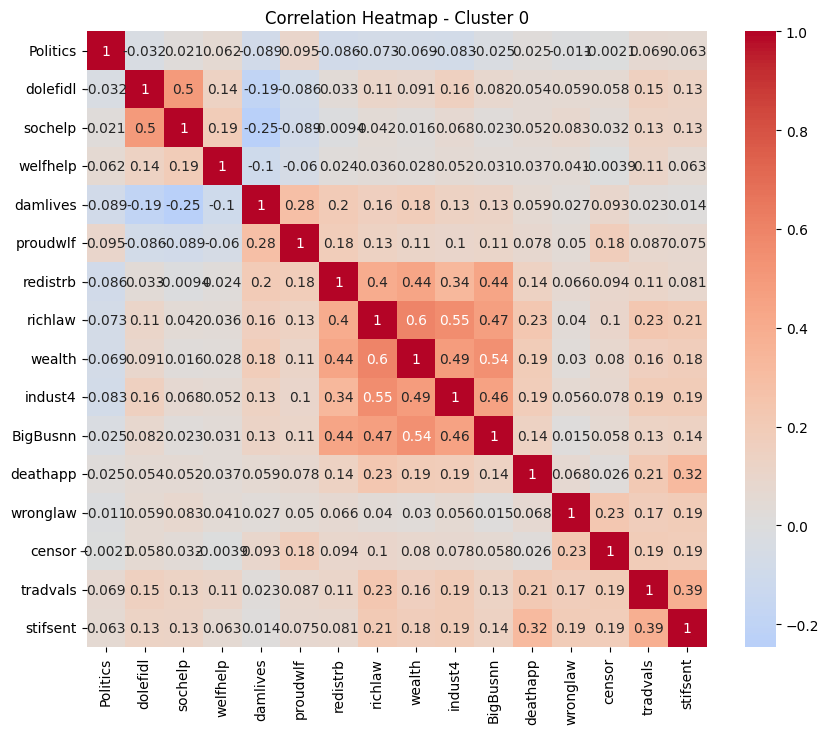

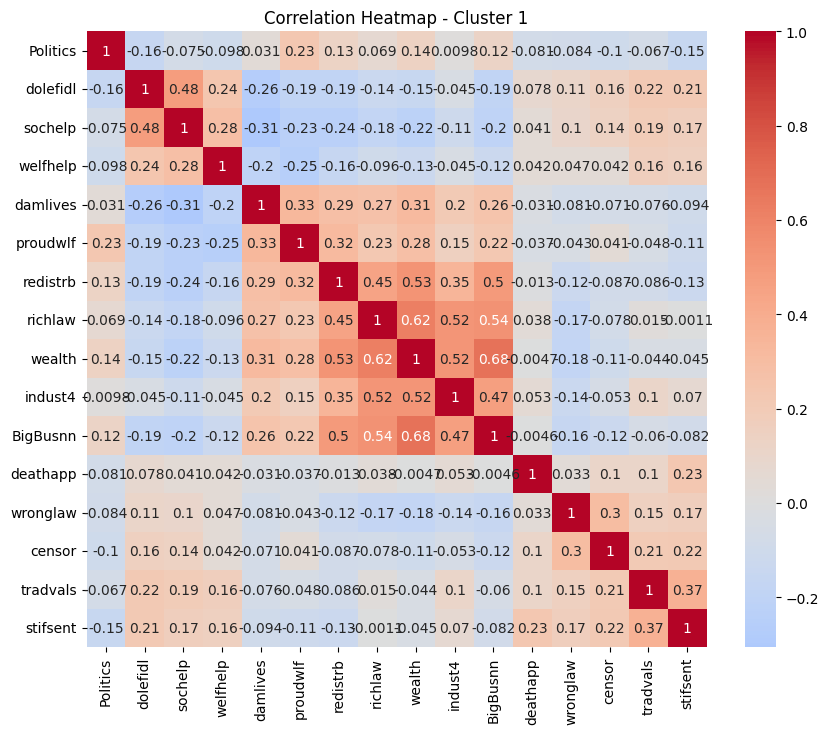

Post-Brexit Data:


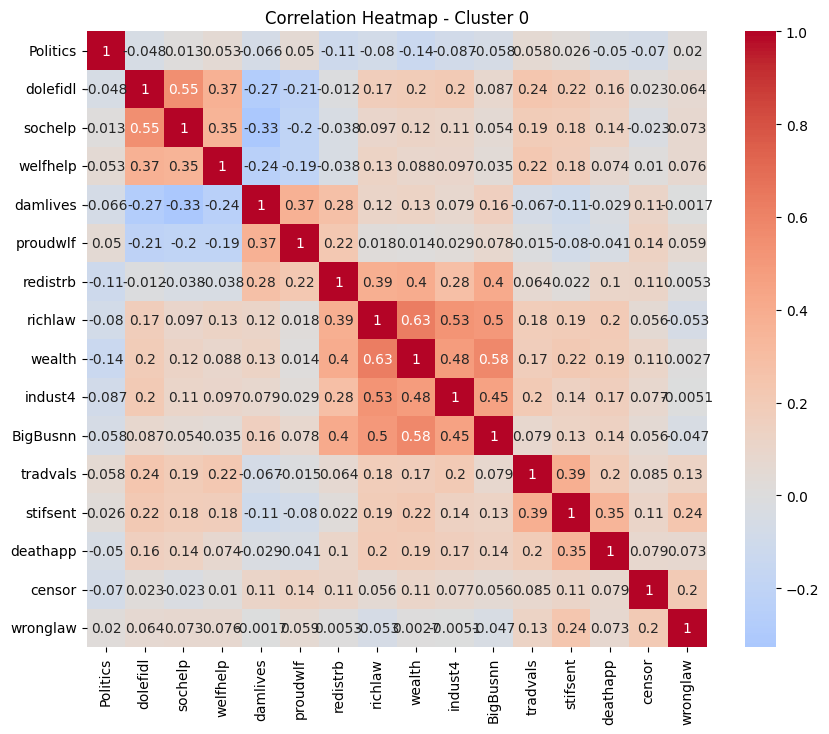

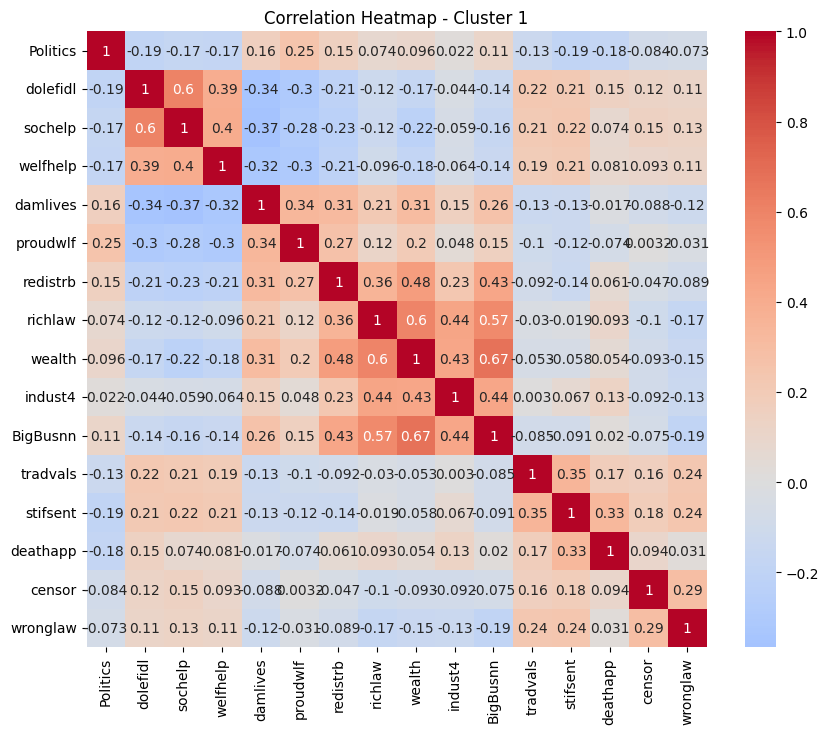

In [69]:
#CORRELATION MATRICES for pre and post data with political attitude
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already defined the dataframes ordinal_columns_pre and ordinal_columns_post

# List of unique clusters in both dataframes
unique_clusters_pre = ordinal_columns_pre['cluster'].unique()
unique_clusters_post = ordi['cluster'].unique()

# Function to calculate and display heatmap for correlation matrix of each cluster
def calculate_and_display_cluster_heatmap(df, unique_clusters):
    for cluster in unique_clusters:
        cluster_df = df[df['cluster'] == cluster].drop(columns=['cluster'])
        correlation_matrix = cluster_df.corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title(f"Correlation Heatmap - Cluster {cluster}")
        plt.show()

# Calculate and display heatmaps for pre-Brexit data
print("Pre-Brexit Data:")
calculate_and_display_cluster_heatmap(ordinal_columns_pre, unique_clusters_pre)

# Calculate and display heatmaps for post-Brexit data
print("Post-Brexit Data:")
calculate_and_display_cluster_heatmap(ordinal_columns_post, unique_clusters_post)

In [70]:
ordinal_columns= data_pre.select_dtypes(exclude=['object'])

Cluster profile difference calaculation

In [72]:


#cluster profile diffrence calculation



# Group data by clusters
pre_clusters = ordinal_columns_pre.groupby('cluster')
post_clusters = ordinal_columns_post.groupby('cluster')

# Define the political attitude ordinal variable columns
political_attitude_columns = ['welfhelp', 'sochelp', 'dolefidl','damlives','proudwlf',
                'redistrb','BigBusnn','wealth','richlaw',
                'tradvals','stifsent','deathapp','censor','wronglaw','Politics','indust4']
# Calculate cluster profiles for pre dataset
pre_cluster_profiles = {}
for cluster_id, cluster_data in pre_clusters:
    cluster_profile = cluster_data[political_attitude_columns].mode().iloc[0]
    pre_cluster_profiles[cluster_id] = cluster_profile

# Calculate cluster profiles for post dataset
post_cluster_profiles = {}
for cluster_id, cluster_data in post_clusters:
    cluster_profile = cluster_data[political_attitude_columns].mode().iloc[0]
    post_cluster_profiles[cluster_id] = cluster_profile

# Compare cluster profiles
for cluster_id in pre_cluster_profiles:
    pre_profile = pre_cluster_profiles[cluster_id]
    post_profile = post_cluster_profiles.get(cluster_id, pd.Series())  # Use empty Series if cluster doesn't exist in post data

    if post_profile.empty:
        print(f"Cluster {cluster_id} does not exist in post dataset.")
    else:
        profile_difference = pre_profile - post_profile
        print(f"Cluster {cluster_id} Profile Difference:\n{profile_difference}")


Cluster 0 Profile Difference:
welfhelp    0
sochelp     0
dolefidl    0
damlives   -1
proudwlf   -1
redistrb   -1
BigBusnn    0
wealth      0
richlaw     0
tradvals    0
stifsent    0
deathapp    0
censor      0
wronglaw    0
Politics    0
indust4     0
Name: 0, dtype: int64
Cluster 1 Profile Difference:
welfhelp    0
sochelp     0
dolefidl    0
damlives    0
proudwlf    1
redistrb    0
BigBusnn    1
wealth      1
richlaw     1
tradvals   -1
stifsent    0
deathapp    0
censor     -3
wronglaw    0
Politics    0
indust4     0
Name: 0, dtype: int64


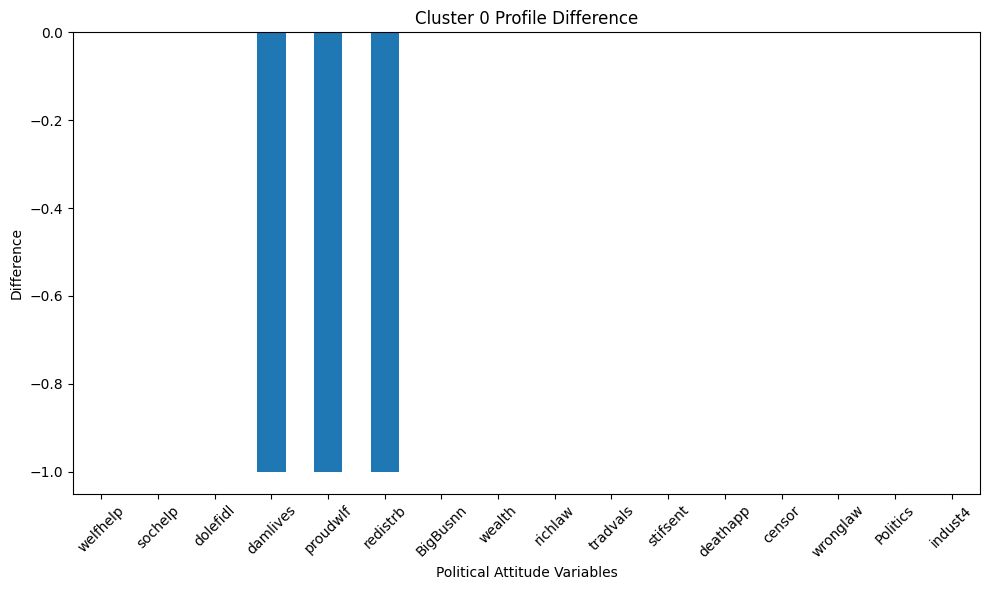

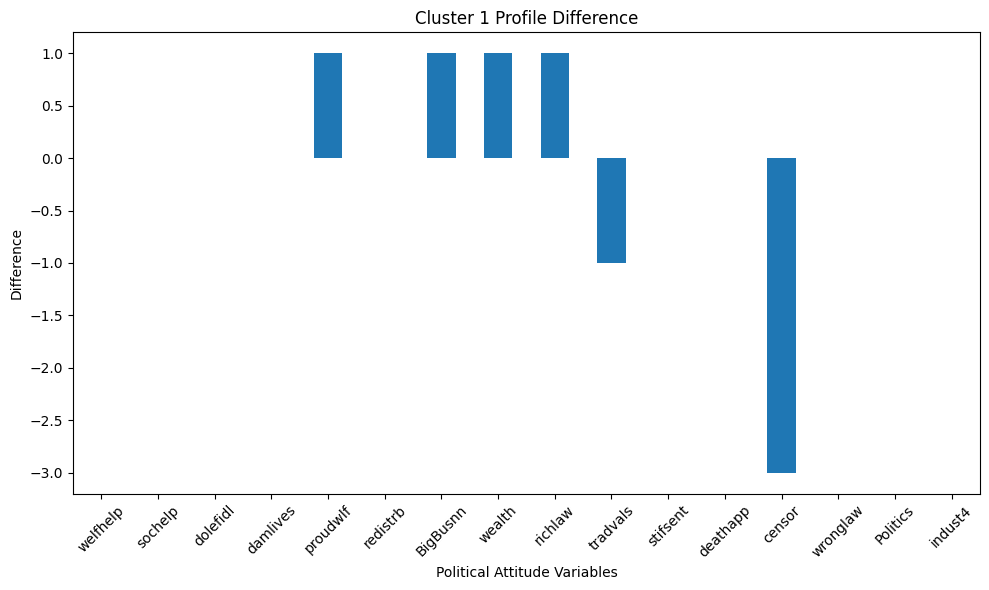

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Import the matplotlib library


# Group data by clusters
pre_clusters = ordinal_columns_pre.groupby('cluster')
post_clusters = ordinal_columns_post.groupby('cluster')

# Define the political attitude ordinal variable columns
political_attitude_columns = ['welfhelp', 'sochelp', 'dolefidl','damlives','proudwlf',
                'redistrb','BigBusnn','wealth','richlaw',
                'tradvals','stifsent','deathapp','censor','wronglaw','Politics','indust4']

# Calculate cluster profiles for pre dataset
pre_cluster_profiles = {}
for cluster_id, cluster_data in pre_clusters:
    cluster_profile = cluster_data[political_attitude_columns].mode().iloc[0]
    pre_cluster_profiles[cluster_id] = cluster_profile

# Calculate cluster profiles for post dataset
post_cluster_profiles = {}
for cluster_id, cluster_data in post_clusters:
    cluster_profile = cluster_data[political_attitude_columns].mode().iloc[0]
    post_cluster_profiles[cluster_id] = cluster_profile

# Create bar plots for profile differences
for cluster_id in pre_cluster_profiles:
    pre_profile = pre_cluster_profiles[cluster_id]
    post_profile = post_cluster_profiles.get(cluster_id, pd.Series())  # Use empty Series if cluster doesn't exist in post data

    if not post_profile.empty:
        profile_difference = pre_profile - post_profile

        # Create a bar plot for profile differences
        plt.figure(figsize=(10, 6))  # Set the figure size
        profile_difference.plot(kind='bar')  # Create a bar plot
        plt.title(f"Cluster {cluster_id} Profile Difference")  # Set the title
        plt.xlabel("Political Attitude Variables")  # Set the x-axis label
        plt.ylabel("Difference")  # Set the y-axis label
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.tight_layout()
        plt.show()  # Display the plot

